# Artistic style transfert


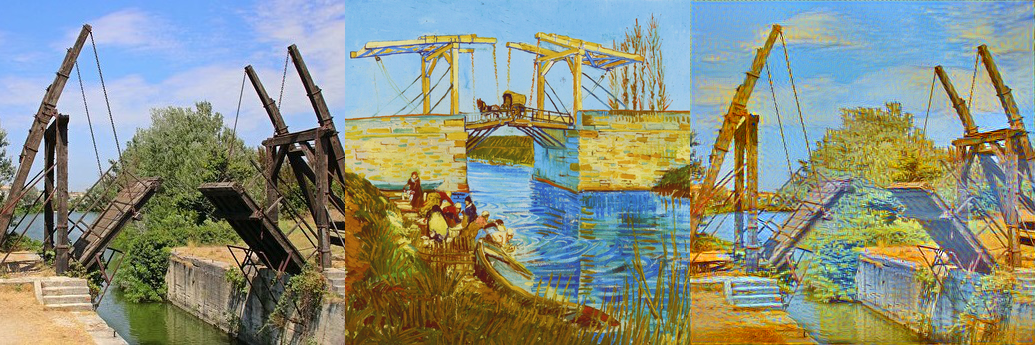



The aim of this project is to recreate the painting "Pont de Van Gogh"
* Extract the style from the Van Gogh painting
* Apply it to a picture of the bridge tooked in Arles.

In a CNN, some layers are dedicated to the content of the input, and some other are dedicated to the "style" of the input.<br>

 

Requierement: Keras with Tensorflow backend <br>


In [1]:
#Dependencies
from PIL import Image
import os
import numpy as np
from math import floor
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import AveragePooling2D, Input, Conv2D
from scipy.optimize import fmin_l_bfgs_b
from keras import backend as K

Using TensorFlow backend.


## Preprocessing the picture

- Load the picures  
- Resize it and transform as array 
- Substract imagenet mean and reverse the channel

In [2]:
#Parametres
iterations  = 10
imagenet_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)#Imagenet mean of each channel

In [3]:
def resizePic(picPath, dest = 224):
    """This function resize a picture in a picture of size (dest,dest).
    Load the picture, resize it and maintain the ratio of the image
    Crop the middle of the picture  
    Input : pictures's path
    """
    
    pic = Image.open(picPath)
    
    #Resize without distortion
    m = min(pic.size)
    ratio = m / dest #Resize the picture then crop the center
    pic2 = pic.resize( ( floor(pic.size[0] /ratio) , floor(pic.size[1] /ratio)  ), Image.ANTIALIAS  )
    
    #Crop the center of the picture
    left = floor((pic2.width - dest)/2)
    top = floor((pic2.height - dest)/2)
    right = floor((pic2.width + dest)/2)
    bottom = floor((pic2.height + dest)/2)
    
    return(pic2.crop((left, top, right, bottom)))
    

In [4]:
def subtract_imagenet_mean(image):
    '''Substract the imagenet mean then reverse the channel'''
    return (image - imagenet_mean)[:, :, :, ::-1]


def add_imagenet_mean(image, s):
    '''Add the imagenet mean and reverse the channel'''
    return np.clip(image.reshape(s)[:, :, :, ::-1] + imagenet_mean, 0, 255)

In [5]:
#Get the minimum size of the pic
size = 1000000
for p in ["D:/Project/DeepLearning/artisticTransfert/Data/original/pont-van-gogh.jpg","D:/Project/DeepLearning/artisticTransfert/Data/original/Vincent_Willem_van_Gogh_-_Pont_de_Langlois_-_Kröller-Müller.jpg"]:
    s = min(Image.open(p).size)
    size = min(s,size)
print('Tranform the pictures as an ({},{},3) shape array'.format(size,size))

Tranform the pictures as an (345,345,3) shape array


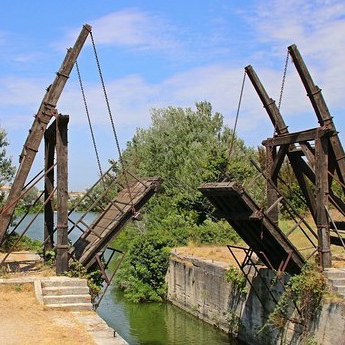

In [6]:
## Step 1 Content picture

#Load & resize the picture to (size,size,3)
pic = resizePic("D:/Project/DeepLearning/artisticTransfert/Data/original/pont-van-gogh.jpg",size)

#Add a channel, substract imagenet mean; then reverse the channel
picArray = subtract_imagenet_mean(np.expand_dims(np.asarray(pic).astype('float32'),axis=0))
picArrayShape = picArray.shape

pic

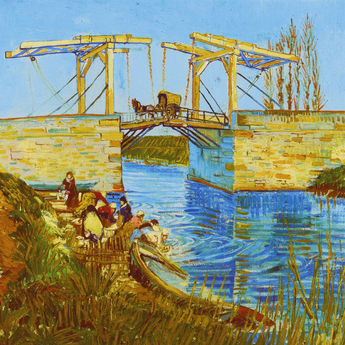

In [7]:
## Step 2 Style picture

#Load & resize the picture
vgStyle = resizePic("D:/Project/DeepLearning/artisticTransfert/Data/original/Vincent_Willem_van_Gogh_-_Pont_de_Langlois_-_Kröller-Müller.jpg",size)

vgStyleArray = subtract_imagenet_mean(np.expand_dims(np.asarray(vgStyle).astype('float32'), axis=0))

vgStyle

## Load VGG16


In [8]:
Vgg16 = VGG16(include_top=False, weights='imagenet',input_shape= (size,size,3))#Load max pooling vgg16

## Extract the content of the picture

In [9]:
#Truncated Vggg16: the output of this model is block2_conv2 activation values
contentLayer = Vgg16.get_layer('block2_conv2').output
contentModel = Model(Vgg16.input, contentLayer)
contentModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 345, 345, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 345, 345, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 345, 345, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 172, 172, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 172, 172, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 172, 172, 128)     147584    
Total params: 260,160
Trainable params: 260,160
Non-trainable params: 0
_________________________________________________________________


In [10]:
# Get 'block2_conv2' activation value for the Content picture
target = K.variable( contentModel.predict(picArray) )

In [11]:
class ConvexOptimiser(object):
    '''Optimiser class; this object enable the user to evaluate the loss and the gradient values of a fonction'''
    def __init__(self, cost_function, tensor_shape):
        self.cost_function = cost_function
        self.tensor_shape = tensor_shape
        self.gradient_values = None
    def loss(self, point):
        '''Evaluate of the loss on point'''
        loss_value, self.gradient_values = self.cost_function([point.reshape(self.tensor_shape)])
        return loss_value.astype('float64')
    def gradient(self, point):
        '''Evalutate the gradient value on point'''
        return self.gradient_values.flatten().astype('float64')

In [12]:
#Mean square error between the target (activation values for content picture) and the activation of an input
mse_loss = K.mean( K.square(contentLayer - target ) )

#Gradient evaluation
grads = K.gradients(mse_loss, Vgg16.input)

#Cost function
cost_function = K.function([Vgg16.input], [mse_loss] + grads)

In [13]:
#Instantiate the optimiser
optimiser = ConvexOptimiser(cost_function, picArrayShape)

In [14]:
def optimise(optimiser, iterations, point, tensor_shape, file_name):
    """This function compute the gradient descent
    It take as input a point (a point is a picture), return a new point with a lower loss
    At the end of the process, the point is reshaped as a picture, and is saved"""
    for i in range(iterations):
        point, min_val, info = fmin_l_bfgs_b(func=optimiser.loss, x0=point.flatten(), fprime=optimiser.gradient, maxfun=20 )
        print( 'Loss: ', min_val)
    array = add_imagenet_mean(point.copy(), tensor_shape)[0].astype('uint8')
    Image.fromarray(array).save("D:/Project/DeepLearning/artisticTransfert/Output/model1/generated_{}_{}.png".format(file_name,i))
    return point
        

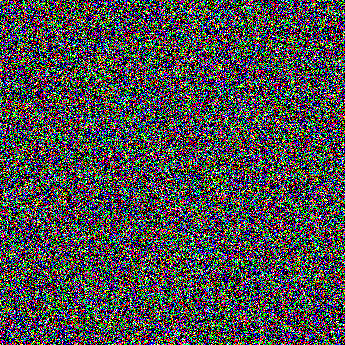

In [15]:
def generate_rand_img(shape):
    '''Create a random numpy array'''
    return np.random.uniform(-2.5,2.5,shape)/1

generated_image = generate_rand_img(picArrayShape  )

Image.fromarray(generated_image[0].astype('uint8'))

Loss:  19801.7265625
Loss:  7839.0458984375
Loss:  3608.64599609375
Loss:  2155.256103515625
Loss:  1492.62353515625
Loss:  1088.196533203125
Loss:  791.7399291992188
Loss:  574.8069458007812
Loss:  421.285400390625
Loss:  316.7795104980469


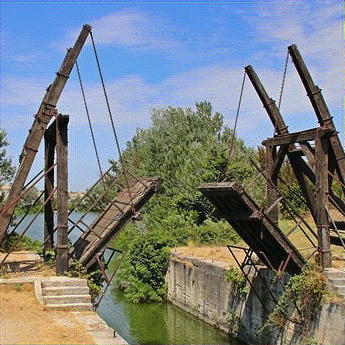

In [16]:
#Compute gradient descent
generated_image = optimise(optimiser, iterations, generated_image, picArray.shape, 'content')
Image.open("D:/Project/DeepLearning/artisticTransfert/Output/model1/generated_content_{}.png".format(iterations-1))

## Style extraction

Extract Van Gogh style in order to apply it to the picture

In [17]:
def grammian_matrix(matrix):
    '''Function return grammian matrix'''
    flattened_matrix = K.batch_flatten(K.permute_dimensions(matrix, (2, 0,1)))
    matrix_transpose_dot = K.dot(flattened_matrix,K.transpose(flattened_matrix))
    element_count = matrix.get_shape().num_elements()
    return matrix_transpose_dot / element_count


$G$ a grammian matrix: $ G = V^{T}V $ <br>
The grammian matrix is the covariance between the columns of the picture <br>
*https://en.wikipedia.org/wiki/Gramian_matrix*

In [18]:
def style_mse_loss(x, y):
    '''MSE of the grammian matrix'''
    return K.mean( K.square( grammian_matrix(x) - grammian_matrix(y)))

In [19]:
outputs = {l.name: l.output for l in Vgg16.layers}
layers = [outputs['block{}_conv2'.format(o)] for o in range(1,6)]

In [20]:
#This model return the activations values of the selected layers
layers_model = Model(Vgg16.input, layers)

#Evaluate the the activation for the style picture
targs = [K.variable(o) for o in layers_model.predict(vgStyleArray)]

In [21]:

#styleloss is the sum of the MSE of each layer
style_loss = sum(style_mse_loss(l1[0], l2[0]) for l1, l2 in zip(layers, targs))


grads = K.gradients(style_loss, Vgg16.input)

style_fn = K.function([Vgg16.input], [style_loss]+grads)


In [22]:
optimiser = ConvexOptimiser(style_fn, picArrayShape)

In [23]:
generated_image = generate_rand_img(picArrayShape  )

Loss:  216989.71875
Loss:  62191.5859375
Loss:  12714.3154296875
Loss:  4306.73876953125
Loss:  2618.881103515625
Loss:  2018.2047119140625
Loss:  1517.1064453125
Loss:  1275.0206298828125
Loss:  1073.208984375
Loss:  915.3207397460938


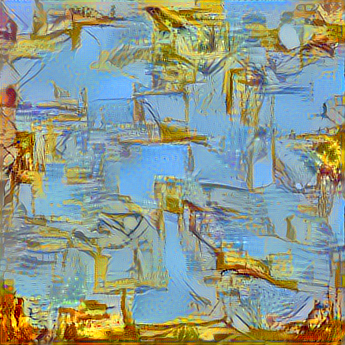

In [24]:
generated_image = optimise(optimiser, iterations, generated_image, picArrayShape, 'style')
Image.open("D:/Project/DeepLearning/artisticTransfert/Output/model1/generated_style_{}.png".format(iterations-1))

## Style transfert

For doing a style transfert we have to combine both of those methods. <br>

In [25]:
#The content loss is about 3 time the style loss.
#Let's add weight to make both of this loss have the same order
weightStyle = 900
weightContent =3316

#Global loss is the average activation error
loss = style_loss / weightStyle + mse_loss / weightContent

grads = K.gradients(loss, Vgg16.input)

fn = K.function([Vgg16.input], [loss]+grads)


In [26]:
tr_opt = ConvexOptimiser(fn, picArrayShape)

In [27]:
generated_image = generate_rand_img(picArrayShape  )

Loss:  326.07977294921875
Loss:  102.32557678222656
Loss:  47.198062896728516
Loss:  33.45753860473633
Loss:  29.270328521728516
Loss:  27.384008407592773
Loss:  26.13414764404297
Loss:  25.371652603149414
Loss:  25.0302677154541
Loss:  25.0302677154541


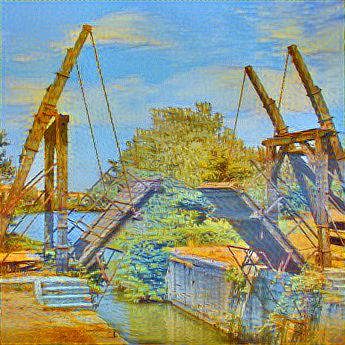

In [28]:
generated_image = optimise(tr_opt, iterations, generated_image, picArrayShape, 'transfert')
Image.open("D:/Project/DeepLearning/artisticTransfert/Output/model1/generated_transfert_{}.png".format(iterations-1))

## Lets try on other pictures


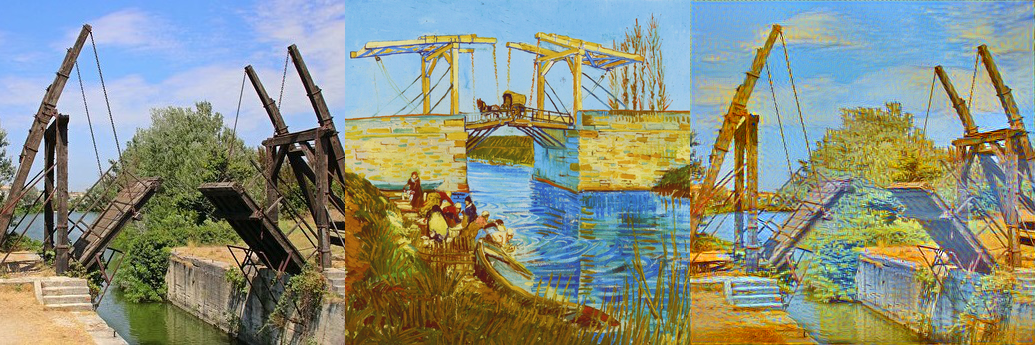
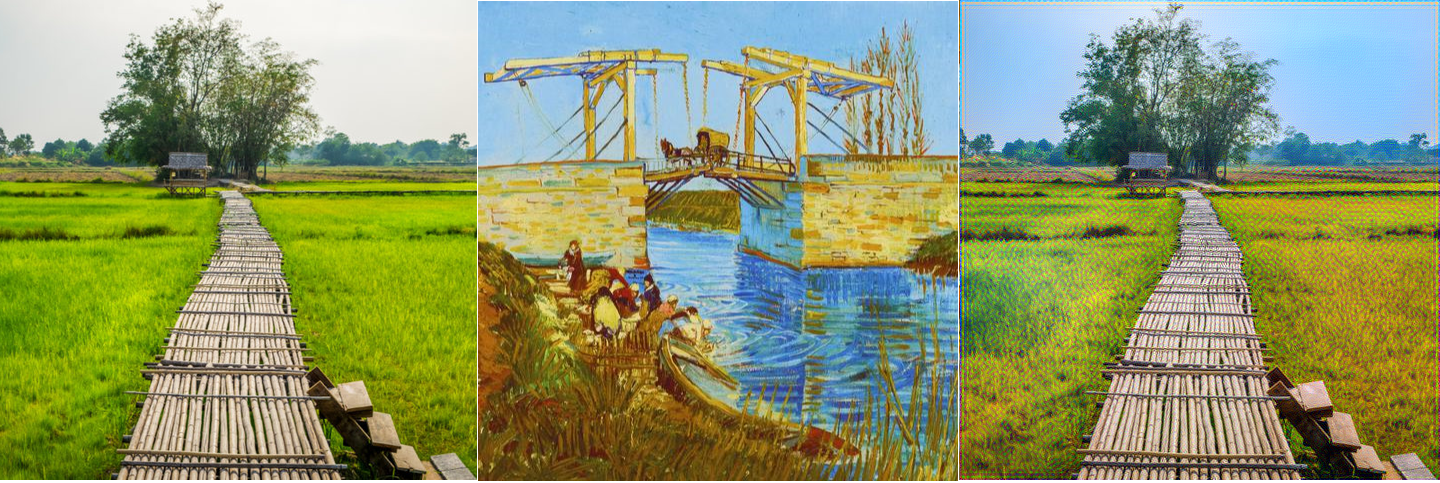
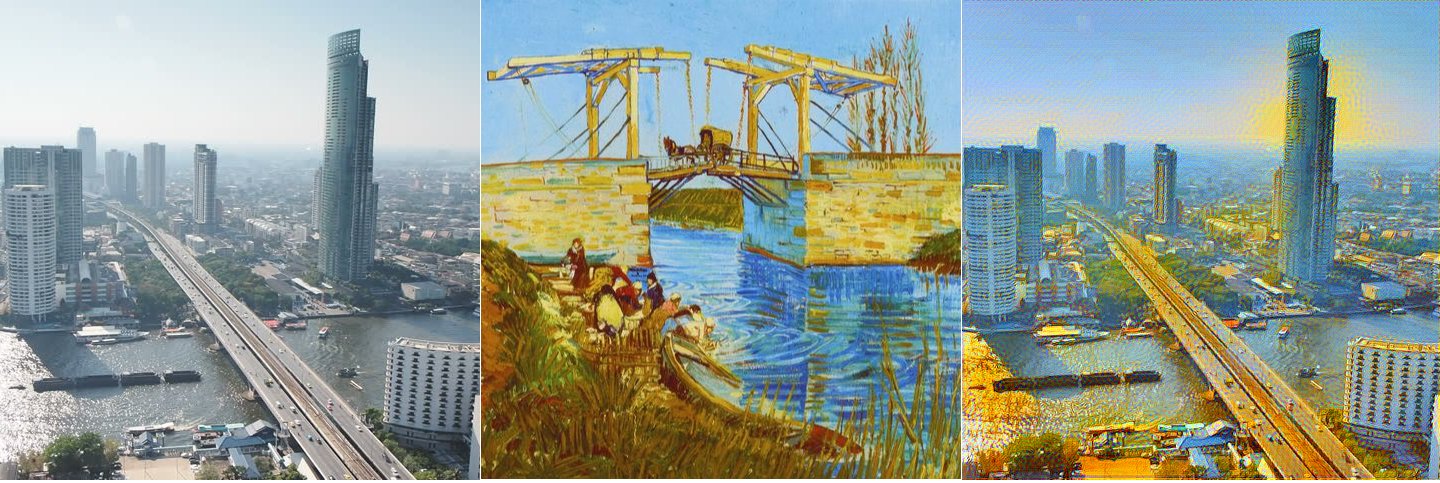